[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Humboldt-WI/bads/blob/master/tutorials/7_nb_model_selection.ipynb) 


# Chapter 7 - Regularization and model selection 
We are well on the way through our journey on learning the inner workings of machine learning models and how to implement them ourselves. Now that we can create models and assess them, let's think a bit more about refining models. This section will primarily tackle the problem of overfitting and variable selection.

As you've probably heard by now, overfitting occurs when the model internalizes too much noise from the training data. The training data is a sample. It will contain idiosyncracies that do not occur in the population. Additionally, if we include irrelevant variables in our model, the model may find spurious correlations. When presented with new data, the model will assume the exact same patterns exist. Therefore, predictions will be less accurate as this noise is factored into predictions. There are many ways to address these problems. This notebook will present just a few of those methods.

The outline of the tutorial is as follows:
- Preliminary preparation of data and setting up the environment
- Regularization with the example of logistic regression
- Overfitting with decision trees
- Grid search hyperparameter tuning

# Preliminaries
As usual, we begin by importing our standard libraries and also our standard modeling data. Normally in a notebook, you would import all necessary libraries here. However, since we want to highlight certain functions, we will be importing libraries throughout this notebook for that illustrative purpose.

In [1]:
# Import standard Python libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd 
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
import statsmodels.api as sm
from pprint import pprint

# Set seed for replication
np.random.seed(888)

# Suppress output in scientific notation
np.set_printoptions(suppress=True)

# Some configuration of the plots we will create later
%matplotlib inline  
plt.rcParams["figure.figsize"] = (12,6)

In [2]:
# Load credit risk data in pre-processed format from GitHub
data_url = 'https://raw.githubusercontent.com/Humboldt-WI/bads/master/data/hmeq_modeling.csv' 
df = pd.read_csv(data_url, index_col="index")

# Extract target variable and feature matrix 
X = df.drop(['BAD'], axis=1) 
y = df[['BAD']]

# Change variables into easiest data type for model to handle
y = y.values.astype(int)
X = X.astype(float)

In this section, we will focus on variables which are only loosely correlated with the target. Some of these variables may only have spurious correlations. As such, patterns in the training data may not generalize to the population. You may already have made some experiences concerning regression with unnecessary variables from courses like applied econometrics, for example. In that case, you will know the negative effect of spurious correlations and noise variables on predictive ability. We will also try to correct these adverse effects through a method called **regularization**.

# Regularized logistic regression 
Regularization is an approach to find a better balance between bias and variance in the **bias-variance trade-off**, and, thereby, reduce the error of a model. Remember that the (generalization) error of a model is a function of bias and variance. 
Complex models often show a high variance. Model complexity and bias are closely connected (low complexity -> high bias and vice versa). Introducing bias can reduce error by reducing variance. Enter: regularization. 

![bias and variance](https://miro.medium.com/max/1050/1*oO0KYF7Z84nePqfsJ9E0WQ.png)
Image source: [Giorgos Papachristoudis: The Bias-Variance Tradeoff](https://towardsdatascience.com/the-bias-variance-tradeoff-8818f41e39e9)

How can we implement this idea of increasing bias to reduce variance? The answer depends on the type of model but at least for regression-type models the answer is: add a complexity penalty. 

In a regression setting, large coefficients are indicators of complex, unstable models. Possible causes include high dimensionality and multicollinearity. The aim of the model is to minimize the magnitude the coefficients have on the model. Therefore, it is included in the loss function. 

$$ \min\limits_{\beta} ⁡\mathcal{L} (\beta)+\lambda|(\beta)| $$

This penalty produces sparser models as it forces the coefficients to zero. Furthermore, we also have a new meta-parameter $\lambda$, which governs the strength of regularization. Simply put, $\lambda$ embodies our preference for models that fit the training data more accurately (low $\lambda$) or models that are less complex (high $\lambda$). It is hard to impossible to tell suitable settings of $\lambda$ a priori. Thus, we typically tune this *hyperparameter* for each data set. We will get to hyperparamater tuning later in the notebook.

We have discussed two common forms of regularization. Both approaches work by including a measure of coefficient size into the loss function (i.e. the function which the algorithm optimizes) in the form of a penalty. Intuitively, instead of telling the algorithm to build a model that fits well, we now tell it to build a model that fits well *and* keeps the coefficients small by deducting points in relation to the size of coefficients. 

The difference between the *lasso* and *ridge* penalty is then only whether we subtract the absolute or the squared sum of coefficients. While lasso tends to set coefficients to 0 completely, the ridge penalty reduces the coefficient size more evenly. We will see that "why not both?" is also a legitimate suggestion and leads to the *elastic net* penalty.

So to reiterate, we have a complex model that does not generalize well to unseen samples (i.e., does not *generalize* well). We will handle this by penalizing high parameter values through a constrained minimization. This will add bias to our model but also reduce the variance in its accuracy with new predictions. 

## Options for regularizing the logistic regression model 

### Lasso or L1 Regularization
Least Absolute Shrinkage and Selection Operator or LASSO (often stylized as simply as lasso) is a regularization technique in which the penalty is equivalent to the residual of the sum of squares plus the absolute sum of coefficients multiplied by some shrinkage value (represented by $\lambda$ below). As such, lower coefficient values $\beta_i$ will achieve the minimum value. To carry this method out, the new objective function to solve would be:

$$ \arg\min_{\beta_j} \sum_{i=1}^{n}(y_i - \sum_{j}x_{ij} \beta_j)^2 + \lambda \sum_{j=1}^{p} |\beta_j | $$

Lasso regression **should only be done after standardization of continuous variables** when the analyst believes that certain features need to be eliminated. Standardization is crucial to ensure that every feature, independent of the magnitude of common feature values (e.g., several thousands for a feature *salary* as opposed to small int value for a feature *years of education*) has the same chances of *surviving* lasso regularization. Here, survive means receiving a non-zero coefficient. Intuitively, shrinking the coefficient of a feature with large values (e.g., salary) will reduce the penalty more than shrinking the coefficient of a feature with smaller feature values (e.g., years of education). Lasso performs **embedded feature selection** meaning that it is likely to set some coefficients to zero, which is equivalent to discarding the feature. If two or more variables are highly correlated, lasso will arbitrarily select one of them and assign a non-zero coefficient, while the other correlated features are likely to receive a coefficient value of zero. This behavior is sometimes desirable, for example to remove *redundant features* but also cause problems, for example if the features are dummy codes originating from the same categorical variable.

### Ridge or L2 Regularization
Ridge regression appears similar to lasso regression but note the key difference: ridge regression is equal to the sum of the squared residuals plus the sum of the **square of the coefficients** multipled by some shrinkage value. Here is the objective function for L2 regularization:

$$ \arg\min_{\beta_j} \sum_{i=1}^{n}(y_i - \sum_{j}x_{ij} \beta_j)^2 + \lambda \sum_{j=1}^{p} |\beta_j^2 | $$

Again, it is **best to standardize all continuous variables before** performing this regression. The reason is the same as for Lasso. Ridge regression never really sets coefficient values to zero due to the square. So, if all parameters are believed to hold some importance, it may be better to use this method of regularization. Note that ridge regression only works if the number of coefficients is less than the number of observations.

### Elastic Net
Elastic Net (enet) is a combination of L1 and L2 regularization. It is best used when an analyst is unsure whether ridge or lasso is more suitable for a given data set. The enet penalty specifies two separate shrinkage values. 

$$ \arg\min_{\beta_j} \sum_{i=1}^{n}(y_i - \sum_{j}x_{ij} \beta_j)^2 + \lambda_1 \sum_{j=1}^{p} |\beta_j | + \lambda_2 \sum_{j=1}^{p} |\beta_j^2 | $$

One of the bigger disadvantages of enet is the computational cost required to find the best combination of the two shrinkage values. It is also important to check if lasso alone might have done a better job at preventing overfitting.

## Working example of regularization with logit
We have looked at a manual implementation of the logistic regression model in [Tutorial 5](https://github.com/Humboldt-WI/bads/blob/master/tutorials/5_nb_supervised_learning.ipynb). When adding a penalty term to the likelihood function for regularizing our model, we also need to adjust model fitting. Specifically, we now have to minimize the regularized likelihood function. We can still use *gradient descent* but have to adjust the computation of the gradient. Going through this process and implementing regularized logistic regression from scratch would be a perfect exercise to further sharpen your data science skills. Have a look at [Tulrose Deori's post](https://towardsdatascience.com/implement-logistic-regression-with-l2-regularization-from-scratch-in-python-20bd4ee88a59) for some inspiration if needed. 

In this tutorial, we skip the from scratch implementation and move straight to estimating regularized logit models using our beloved Python libraries. 

### Benchmark
The idea of regularization is to build better models with more stable and accurate predictions. In order to prove this can be achieved through regularization, we will need a benchmark for comparison.

Let's train a normal logistic regression model with all available variables. We will first split the data into a training set and a test set. We will train our model on the training data, then predict using the test set (which the model has never seen) and compare the model's predictions with the actual labels.

We can look at a number of measures to verify that the regularization is worthwhile. This would be metrics like accuracy, AUC and coefficient values. Here, we will focus on AUC and plot the ROC for illustrative purposes.

In [3]:
# Split data into training and test

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=888)

print("Remember the shape of our data: ")
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

Remember the shape of our data: 
(4172, 18) (4172, 1) (1788, 18) (1788, 1)


In [4]:
# Fit the logistic regression

logit = sm.Logit(y_train, X_train, )

logit_res = logit.fit()

print(logit_res.summary())

Optimization terminated successfully.
         Current function value: 0.408015
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                 4172
Model:                          Logit   Df Residuals:                     4154
Method:                           MLE   Df Model:                           17
Date:                Tue, 01 Dec 2020   Pseudo R-squ.:                  0.1833
Time:                        15:58:14   Log-Likelihood:                -1702.2
converged:                       True   LL-Null:                       -2084.3
Covariance Type:            nonrobust   LLR p-value:                1.904e-151
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
LOAN                -0.1161      0.049     -2.364      0.018      -0.212      -0.020
MORTDUE    

Amazingly easy! We see that certain variables have high p-values like `VALUE`, `JOB_Other` and `JOB_ProfExe` among others. While this is already a hint that they may not be suitable for our model, we can see how regularization evaluates them as well.

Let's now evaluate the predictive performance of our model using the test set. We can first check accuracy then plot the AUC for the test set. We will use these for comparison with models with regularization.

In [5]:
# Get predictions in probabilty of class 1

logit_test_prob = logit_res.predict(X_test)

logit_test_prob

index
2698    0.065587
2542    0.130708
2683    0.458780
2796    0.080445
5906    0.280446
          ...   
3       0.205215
188     0.306660
5828    0.193898
5235    0.291001
2220    0.162628
Length: 1788, dtype: float64

In [6]:
# Calculate the AUC

fpr_logit, tpr_logit, _ = metrics.roc_curve(y_test, logit_test_prob)
auc_logit = metrics.auc(fpr_logit, tpr_logit)
auc_logit

0.7922727441780346

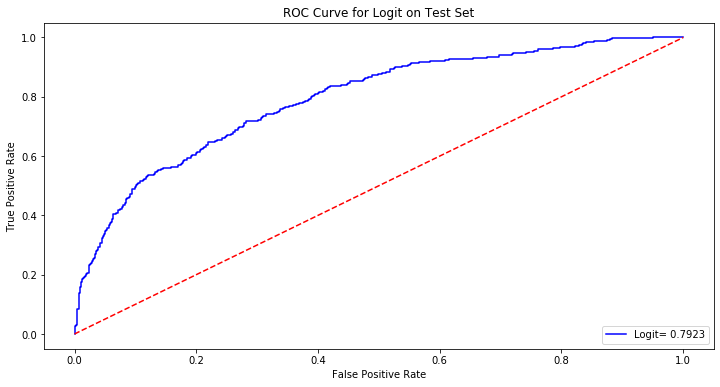

In [7]:
# Plot of AUC
plt.plot(fpr_logit, tpr_logit, label="Logit= %0.4f" % auc_logit, color='b')

# Random benchmark
plt.plot([0, 1], [0, 1], "r--");  

# Plot configuration
plt.title('ROC Curve for Logit on Test Set')
plt.ylabel("True Positive Rate")
plt.xlabel("False Positive Rate")
plt.legend(loc="lower right")
plt.show()

Overall, the model has done pretty well without regularization. Note that regularization is not guaranteed to give better models and predictions. Let's see whether it does for this data set. 

### Regularization in sklearn 

Now that we have a benchmark model, let's compare that to the methods of regularization that were introduced at the beginning of this notebook. Again, those three models are:
- Lasso (L1)
- Ridge (L2)
- Elastic Net

We will be using the `statsmodels` function for the regular logistic regression and lasso (by calling the `fit_regularized` method). For ridge and elastic net, the `LogisticRegression` function from sklearn with the solver `'saga'` is being used because it is compatible with Ridge and Elastic Net regression alike. The only reason for using `statsmodels` for L1-regularized logistic regression is that it allows for richer comparisons to our benchmark - vanilla - logit model. You could, and typically would, also use `sklearn` for building a logistic regression model with lasso penalty. 

#### Lasso Regression Example

Let's first take a look at lasso regression. `statsmodels` can implement this type of regularization by conveniently calling the `fit_regularized` method on a previously set up logit. As already explained, this form of regularization will remove variables if their coefficients are too low.

In [8]:
lasso = logit.fit_regularized(alpha=7)  # the argument alpha controls the degree of regularization. Above we call this hyperparameter  lamda

print(lasso.summary())

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.42392106763045023
            Iterations: 109
            Function evaluations: 110
            Gradient evaluations: 109
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                 4172
Model:                          Logit   Df Residuals:                     4157
Method:                           MLE   Df Model:                           14
Date:                Tue, 01 Dec 2020   Pseudo R-squ.:                  0.1792
Time:                        16:06:07   Log-Likelihood:                -1710.8
converged:                       True   LL-Null:                       -2084.3
Covariance Type:            nonrobust   LLR p-value:                2.264e-150
                       coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------

C:\ProgramData\Anaconda3\envs\adams\lib\site-packages\scipy\stats\_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
C:\ProgramData\Anaconda3\envs\adams\lib\site-packages\scipy\stats\_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
C:\ProgramData\Anaconda3\envs\adams\lib\site-packages\scipy\stats\_distn_infrastructure.py:1912: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


As we can see, some variables were deemed too costly to add at this value of the regularization parameter (e.g., alpha in the above code). This also includes the variables that we mentioned before, the ones with high p-value (`VALUE`, `JOB_Other` and `JOB_ProfExe`).

The coefficients for these variables were indeed set to 0. Let's now directly compare the values of all coefficients between a normal versus lasso logit model in a bar chart. As expected, the lasso penalty has decreased coefficient values in general and set some coefficients to zero.

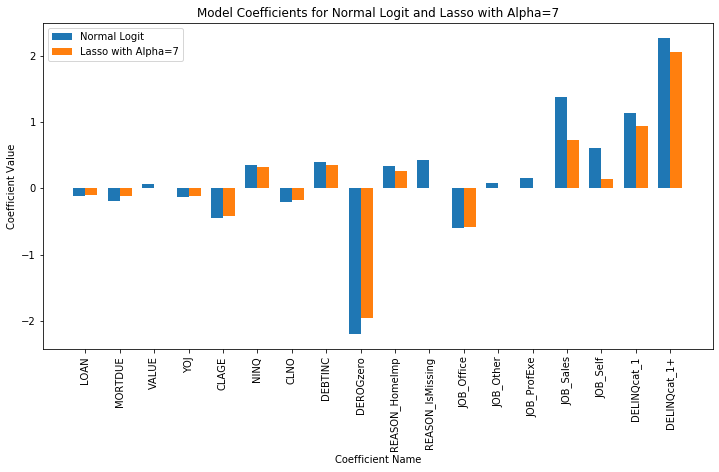

In [15]:
var_names = X_train.columns

coef_logit = pd.Series(logit_res.params, var_names)
coef_lasso =  pd.Series(lasso.params, var_names)

ind = np.arange(len(coef_logit))
width = 0.35 

fig, ax = plt.subplots()
rects1 = ax.bar(ind - width/2, coef_logit, width,
                label='Normal Logit')
rects3 = ax.bar(ind + width/2, coef_lasso, width,
                label='Lasso with Alpha=7')

ax.set_ylabel('Coefficient Value')
ax.set_xlabel('Coefficient Name')
ax.set_title('Model Coefficients for Normal Logit and Lasso with Alpha=7')
ax.set_xticks(ind)
ax.set_xticklabels(var_names, rotation=90)
ax.legend();

Let's also check the AUC and plot the ROC curves of the two models to examine their predictive performance. After all, our main goal of incorporating a penalty is to raise model performance.

In [16]:
lasso_test_prob = lasso.predict(X_test)

lasso_test_prob

index
2698    0.086114
2542    0.138589
2683    0.450748
2796    0.097606
5906    0.255347
          ...   
3       0.161320
188     0.316488
5828    0.211542
5235    0.223000
2220    0.175677
Length: 1788, dtype: float64

In [17]:
fpr_lasso, tpr_lasso, _ = metrics.roc_curve(y_test, lasso_test_prob)
auc_lasso = metrics.auc(fpr_lasso, tpr_lasso)
auc_lasso

0.795269610289958

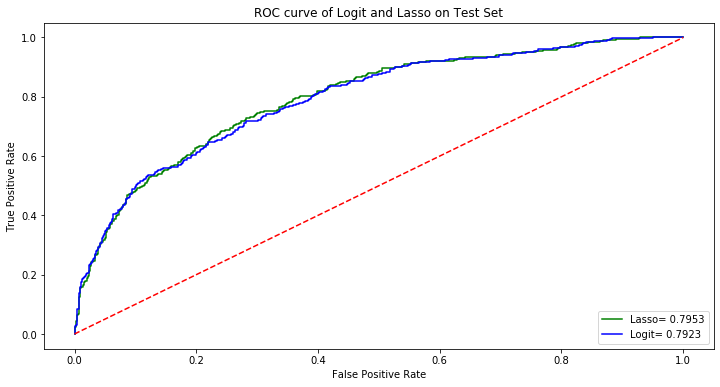

In [18]:
plt.plot(fpr_lasso, tpr_lasso, label="Lasso= %0.4f" % auc_lasso, color='g')
plt.plot(fpr_logit, tpr_logit, label="Logit= %0.4f" % auc_logit, color='b')

# Random benchmark
plt.plot([0, 1], [0, 1], "r--");  

# Plot configuration
plt.title('ROC curve of Logit and Lasso on Test Set')
plt.ylabel("True Positive Rate")
plt.xlabel("False Positive Rate")
plt.legend(loc="lower right")
plt.show()

Puh! At least we see a small increase in AUC. We could check more values for alpha and other arguments in this model for even better performance but methods for that will come at the end of this notebook. While the AUC and ROC are very similar between the regressions, note that now the variance in prediction accuracy will also have fallen. The model's predictions will be more consistently accurate. We will demonstrate this later in the notebook when comparing all models.

#### Ridge Regression Example

Unlike lasso, ridge regression can't set any variables perfectly to 0 because of the square term. To demonstrate that ridge performs differently, we will show here how the same settings yields different results with this form of regularization.

We will be using the `LogisticRegression` function from `sklearn`. Note that the solver `'saga'` is being used in the function because it is compatible with all forms of regularization and penalties. The argument `C` is equivalent to $ \frac{1}{\lambda}$. You can find more information on the function [here](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html).

In [19]:
ridge = LogisticRegression(penalty='l2', fit_intercept=False, solver='saga', C=.5, random_state=888) # C=.5 was chosen through some experimental tuning in this case
ridge.fit(X_train, y_train.ravel())

LogisticRegression(C=0.5, class_weight=None, dual=False, fit_intercept=False,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=888, solver='saga', tol=0.0001, verbose=0,
                   warm_start=False)

Unlike `statsmodels`, we cannot see a simple summary of the regression in `sklearn`. We can use the attribute `.coef_` to inspect the model's coefficients although this is maybe not super helpful. After all, the lack of a nice regression table was our motivation to start with a demo of lasso using the `statsmodels` package. 

In [14]:
ridge.coef_

array([[-0.12066314, -0.1867322 ,  0.06200638, -0.12699116, -0.43965745,
         0.34112175, -0.19270423,  0.38961082, -2.06556986,  0.31895335,
         0.35934044, -0.65560438, -0.00841112,  0.05683505,  1.11614947,
         0.46853396,  1.0633852 ,  2.16080956]])

Compared to lasso regression, we can see that the same strength set no variables perfectly to 0. Ridge regression is more targeted at reducing extreme values. The square term implies that high coefficient values are very costly for the minimization.

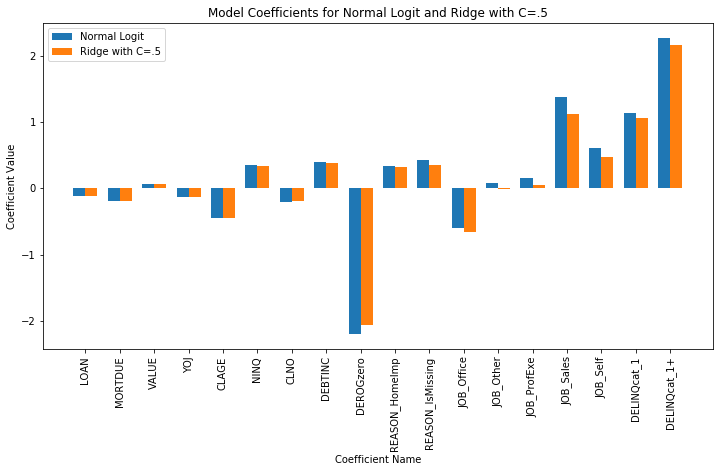

In [21]:
coef_logit = pd.Series(logit_res.params, var_names)
coef_ridge =  pd.Series(ridge.coef_[0], var_names)

ind = np.arange(len(coef_logit))
width = 0.35 

fig, ax = plt.subplots()
rects1 = ax.bar(ind - width/2, coef_logit, width,
                label='Normal Logit')
rects2 = ax.bar(ind + width/2, coef_ridge, width,
                label='Ridge with C=.5')

ax.set_ylabel('Coefficient Value')
ax.set_xlabel('Coefficient Name')
ax.set_title('Model Coefficients for Normal Logit and Ridge with C=.5')
ax.set_xticks(ind)
ax.set_xticklabels(var_names, rotation=90)
ax.legend();

We can now check the AUC and the ROC of the test set to see if this model gives us desirable results. As we can see, this model gives a very comparable AUC to the other models.

In [22]:
# Check probability of class 1 according to the model

ridge_pred = ridge.predict_proba(X_test)

ridge_pred[:,1] # chance of the observation being class 1, format is different from statsmodels predictions

array([0.0749398 , 0.13465718, 0.45864032, ..., 0.20914243, 0.2806098 ,
       0.16796918])

In [23]:
fpr_ridge, tpr_ridge, _ = metrics.roc_curve(y_test, ridge_pred[:,1]) 
auc_ridge = metrics.auc(fpr_ridge, tpr_ridge)

auc_ridge

0.7929480667179521

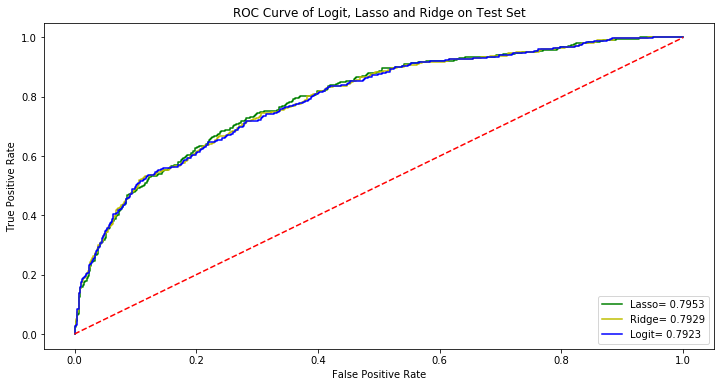

In [24]:
plt.plot(fpr_lasso, tpr_lasso, label="Lasso= %0.4f" % auc_lasso, color='g')
plt.plot(fpr_ridge, tpr_ridge, label="Ridge= %0.4f" % auc_ridge, color='y')
plt.plot(fpr_logit, tpr_logit, label="Logit= %0.4f" % auc_logit, color='b')

# Random benchmark
plt.plot([0, 1], [0, 1], "r--");  

# Plot configuration
plt.title('ROC Curve of Logit, Lasso and Ridge on Test Set')
plt.ylabel("True Positive Rate")
plt.xlabel("False Positive Rate")
plt.legend(loc="lower right")
plt.show()

We obtain a marginal improvement of the AUC due to L2 regularization. However, we will soon show that the model's predictions will be more consistent with the application of regularization. Stable preditive accuracy is important for building trust in a model.

#### Elastic Net Regression Example

Elastic net is a combination of L1 and L2 regressions. We will need to specify a new argument in this function, `l1_ratio`. This tells the function how much it should apply LASSO regression in the model. We will follow the same procedure as above. In terms of the code, the only difference concerns the way in which we create or model object using the function `LogisticRegressionClassifier`.  

In [25]:
#C=.12 was also chosen by experimenting with which values yielded the highest test AUC at l1_ratio=0.5
elnet = LogisticRegression(penalty='elasticnet', fit_intercept=False, solver='saga', random_state=888, l1_ratio=0.5, C=.12) 
elnet.fit(X_train, y_train.ravel())

LogisticRegression(C=0.12, class_weight=None, dual=False, fit_intercept=False,
                   intercept_scaling=1, l1_ratio=0.5, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='elasticnet',
                   random_state=888, solver='saga', tol=0.0001, verbose=0,
                   warm_start=False)

As you might expect, since elastic net is a mix of L1 and L2 regularization, the resulting coefficients can end up as 0 if the L1 ratio is high enough. However, with the mix of L2, less variables end up at 0 perfectly.

In [26]:
elnet.coef_

array([[-0.1161056 , -0.14296954,  0.02088861, -0.11399524, -0.41730515,
         0.32048626, -0.16627506,  0.36354336, -1.9016038 ,  0.25064385,
         0.08241882, -0.61381275, -0.04722205,  0.        ,  0.6811319 ,
         0.20836986,  0.90754598,  1.95990666]])

Let's go through the same steps with our elastic net model; examine coefficient values and then compare predictive performance. 

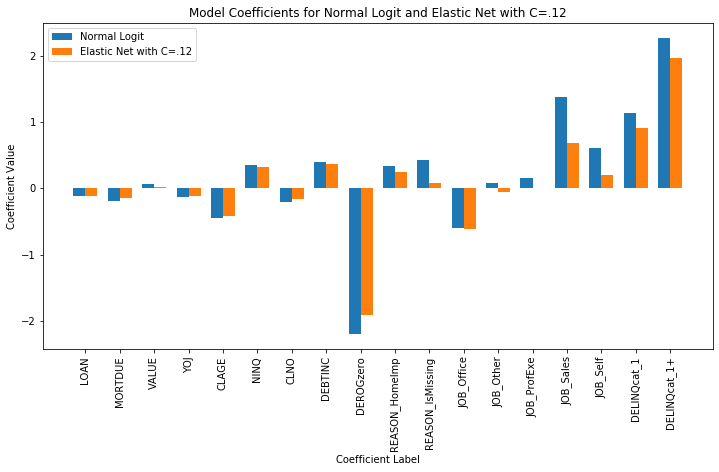

In [28]:
coef_logit = pd.Series(logit_res.params, var_names)
coef_elnet =  pd.Series(elnet.coef_[0], var_names)

ind = np.arange(len(coef_logit))
width = 0.35 

fig, ax = plt.subplots()
rects1 = ax.bar(ind - width/2, coef_logit, width,
                label='Normal Logit')
rects3 = ax.bar(ind + width/2, coef_elnet, width,
                label='Elastic Net with C=.12')

ax.set_ylabel('Coefficient Value')
ax.set_xlabel('Coefficient Label')
ax.set_title('Model Coefficients for Normal Logit and Elastic Net with C=.12')
ax.set_xticks(ind)
ax.set_xticklabels(var_names, rotation=90)
ax.legend()

In [29]:
elnet_pred = elnet.predict_proba(X_test)

elnet_pred[:,1] # chance of the observation being class 1

array([0.08911704, 0.14611348, 0.45546304, ..., 0.21951837, 0.23993896,
       0.18444257])

In [30]:
fpr_elnet, tpr_elnet, _ = metrics.roc_curve(y_test, elnet_pred[:,1]) 
auc_elnet = metrics.auc(fpr_elnet, tpr_elnet)

auc_elnet

0.7942830521446873

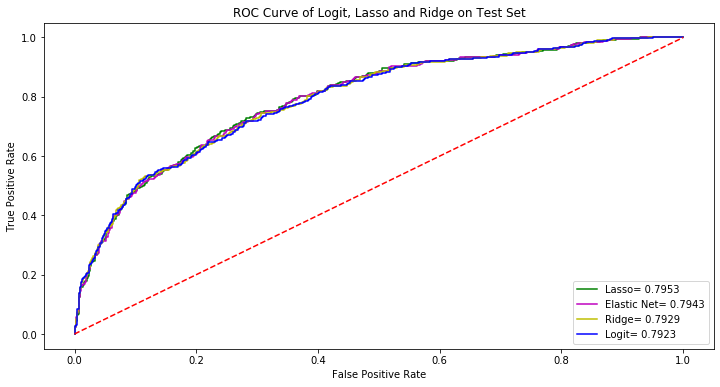

In [31]:
plt.plot(fpr_lasso, tpr_lasso, label="Lasso= %0.4f" % auc_lasso, color='g')
plt.plot(fpr_elnet, tpr_elnet, label="Elastic Net= %0.4f" % auc_elnet, color='m')
plt.plot(fpr_ridge, tpr_ridge, label="Ridge= %0.4f" % auc_ridge, color='y')
plt.plot(fpr_logit, tpr_logit, label="Logit= %0.4f" % auc_logit, color='b')

# Random benchmark
plt.plot([0, 1], [0, 1], "r--");  

# Plot configuration
plt.title('ROC Curve of Logit, Lasso and Ridge on Test Set')
plt.ylabel("True Positive Rate")
plt.xlabel("False Positive Rate")
plt.legend(loc="lower right")
plt.show()

In the case of elastic net, we can see a slight increase in accuracy at a low C value for this `l1_ratio`. If we continue to tune these values, we could very likely find an even better combination of hyperparameter settings. We will discuss this a little later in the notebook when we talk about parameter tuning.

### Bias and variance
The idea of regularization is to introduce bias to reduce variance. Can we confirm this works? Let's use all of our data and run a model with cross-validation and check the accuracy on each run. We can then check the variation across these accuracy values. The goal of regularization was to introduce some bias to reduce variance. Therefore, the variance in predictions without regularization should be higher than those in models with regularization. 

We consider 10-fold cross validation. Increasing the number of folds might facilitate even clearer results but at the cost of increasing runtime. Ten iterations should be enough to see an effect. In case you are a little unsure how cross-validation works, take a look at [Tutorial 6](https://github.com/Humboldt-WI/bads/blob/master/tutorials/6_nb_model_assessment.ipynb), which elaborates on model assessment. 

Before we continue, let's make sure we can run all models in `sklearn`. To that end, we need to create two more model objects, one for vanilla logit and one for lasso; because we showcased these models using `statsmodels` above. 

In [35]:
# create sklearn models for the regular logit and lasso
logit_sk = LogisticRegression(penalty='none', fit_intercept=False, solver='saga', tol=0.01, random_state=888)
lasso_sk  = LogisticRegression(penalty='l1', fit_intercept=False, solver='saga', tol=0.01, random_state=888, C=0.05)

Ok, ready to cross-validate normal logistic regression:

In [41]:
# perform cross validation on logit and check that it outputs what we expect it to
from sklearn.model_selection import cross_val_score

folds = 10
logit_sk_scores = cross_val_score(logit_sk, X, y.ravel(), cv=folds)
print("Accuracy of each cross-validation fold:", logit_sk_scores)
print("Variance in accuracy over folds:", np.var(logit_sk_scores))

Accuracy of each cross-validation fold: [0.79362416 0.79865772 0.79194631 0.80872483 0.81879195 0.83389262
 0.84563758 0.84228188 0.85067114 0.8238255 ]
Variance in accuracy over folds: 0.0004362416107382551


Now let's carry out 5 fold cross validation for every model.

In [42]:
lasso_scores = cross_val_score(lasso_sk, X, y.ravel(), cv=folds)
ridge_scores = cross_val_score(ridge, X, y.ravel(), cv=folds)
elnet_scores = cross_val_score(elnet, X, y.ravel(), cv=folds)

In [43]:
# Let's just verify that we got what we needed from one of those scores

print("Accuracy of each cross-validation fold:", lasso_scores)
print("Variance in accuracy over folds:", np.var(lasso_scores))

Accuracy of each cross-validation fold: [0.80536913 0.80033557 0.80201342 0.81543624 0.8204698  0.8238255
 0.83557047 0.83389262 0.83724832 0.81543624]
Variance in accuracy over folds: 0.00017029075266879884


Lastly, let's test that variance has gone down and simultaneously introduce the `assert` keyword. This keyword is always followed by a condition. If the condition is `False`, `assert` will throw an error. Let's test if the variance of the `logit_sk_scores` is higher than the variance of all other regularized models' cross validation scores.

In [44]:
assert np.var(logit_sk_scores) > np.var(lasso_scores)
assert np.var(logit_sk_scores) > np.var(ridge_scores)
assert np.var(logit_sk_scores) > np.var(elnet_scores)

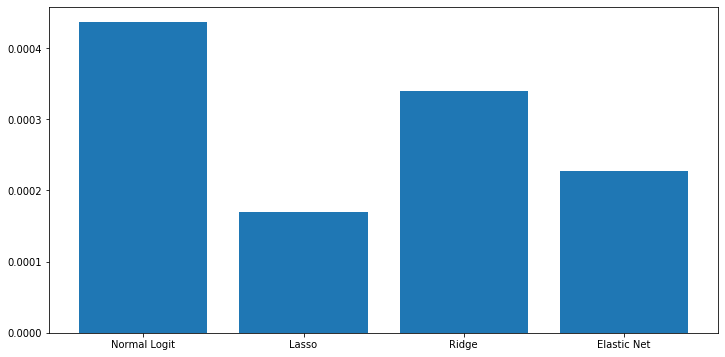

In [45]:
variances = [np.var(logit_sk_scores), np.var(lasso_scores), np.var(ridge_scores), np.var(elnet_scores)]
labels = ["Normal Logit", "Lasso", "Ridge", "Elastic Net"]
plt.bar(labels, variances);

Look at that! The variance in performance of all models with regularization is lower than that in the normal logit model. The goal of the exercise has been achieved. Awesome. Our simpler models vary less in their accuracy. So we can have more trust in those models counting on their accuracy not fluctuating that much with new data from the same population compared to logistic regression modeling without regularization.

### Regularization path
We have seen above that lasso performs feature selection by setting coefficients to zero. A nice feature of regularized linear models is that we can compute the **full regularization path**. This means we can examine the examine the magnitude of coefficient values across different settings of the penalty parameter. The larger the penalty the more emphasize is put on shrinking coefficients, and the less emphasize is put on minimizing the loss. The following codes, which are from the set of [sklearn examples](https://scikit-learn.org/stable/auto_examples/linear_model/plot_lasso_coordinate_descent_path.html#sphx-glr-auto-examples-linear-model-plot-lasso-coordinate-descent-path-py), showcase how to produce a graph of the regularization path. This analysis is useful to inform our choice of penalty values for grid-search. However, for larger data sets, computing the regularization path is a costly exercise. If the goal is to learn which features are most valuable, there are cheaper to establish feature importance. We will learn about these in [Tutorial 9](https://github.com/Humboldt-WI/bads/blob/master/tutorials/9_nb_feature_engineering.ipynb). For now, however, let's see how we can calculate the full regularization path using `sklearn` and re-produce the nice picture from one of the lecture slides.


In [46]:
from sklearn.linear_model import lasso_path
alphas_lasso, coefs_lasso, _ = lasso_path(X, y, fit_intercept=True)

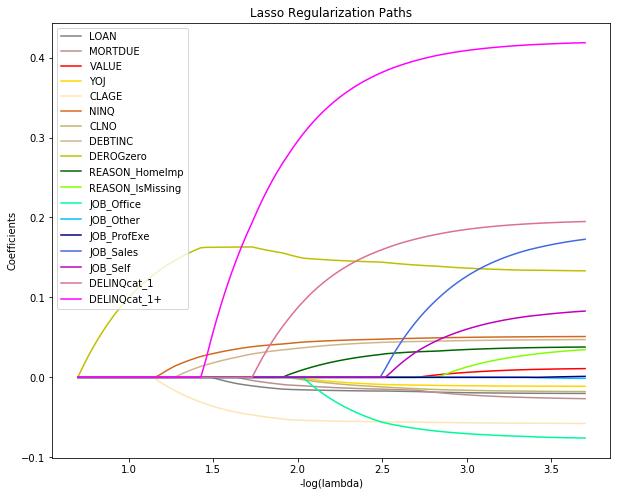

In [49]:
colors = ['gray', 'rosybrown', 'r', 'gold', 'moccasin', 'chocolate', 'darkkhaki', 'tan', 'y', 'darkgreen',
          'chartreuse', 'mediumspringgreen', 'deepskyblue', 'navy', 'royalblue', 'm', 'palevioletred', 'fuchsia']

plt.figure(figsize=[10,8])

neg_log_alphas_lasso = -np.log10(alphas_lasso)

for coef_l, c in zip(coefs_lasso[0], colors):
    l1 = plt.plot(neg_log_alphas_lasso, coef_l, c=c)

plt.xlabel('-log(lambda)')
plt.ylabel('Coefficients')
plt.title('Lasso Regularization Paths')
plt.legend(var_names)
plt.show()

In interpreting the graph, first make sure to note that the x-axis displays the negative of $\log(\lambda)$. The is no specific reason to negate the value of $\lambda$ other than showing increasing coefficient values when reading the plot from right to left. As said, the code comes from the official `sklearn` example series and was copied without adjustments. You can easily change the code if you prefer seeing coefficient values to decrease from left to right. Here, however, reading the plot from left to right, we see the magnitude of  coefficients values when the **degree of regularization decreases**.    

Apparently, the feature *DEROGzero* is most important. Drawing on our expertise with this data set, as developed in [the data preparation Tutorial](https://github.com/Humboldt-WI/bads/blob/master/tutorials/4_nb_data_preparation.ipynb), it makes good sense that the number of major derogatory reports, which is what this variable captures, is related to credit risk. Likewise, the number of delinquent credit lines (DELINQcat_1+) coming out as important makes good sense. In fact, both these important features are actually dummy variables, which we created in [Tutorial 4](https://github.com/Humboldt-WI/bads/blob/master/tutorials/4_nb_data_preparation.ipynb) by first discretizing and then dummy-encoding the the original numerical features. Discussing coefficient values and importance of dummy variables in a regression model is an interesting topic in its own right, but beyond the scope of this notebook. A comprehensive analysis of the plot requires a deep understanding of the original features and ideally some domain knowledge. For now, it would be sufficient if you can interpret the above plot in principle.

# Model selection
Above, we found evidence that hyperparameters affect model performance (e.g. decision tree depth, l1 ratio, ...). Not only that, we have many of them to tune. How can we ensure we choose good settings? Let's go back to the example of regularization and examine a few ways to tune hyperparameters.

## Overfitting

Ultimately, regularization is a way to address one of the key problems in predictive modeling: overfitting. While linear regression models are less prone to overfitting as they drastically simplify relationships, it can still occur.

To see a really good example of a model that can easily be overfit, we can take a look at decision trees. When trees are grown to deep, they start to internalize idiosyncacies of the specific data that they were fed. This means that they assume that all little random variations would also occur in new sets of data that they come across instead of generalizing trends.

Let's take a look at what this looks like by generating a tracking the accuracy of a decision tree on training and test data as we increase the depth of the tree. We will do the same for AUC. Before commencing, how do you think the two metrics will trend as the tree becomes deeper?

In [50]:
from sklearn import tree

train_auc_list = []
test_auc_list = []

for n in range(1,30):
  # Fit tree to training data
  dt = tree.DecisionTreeClassifier(max_depth=n, random_state=888)
  dt = dt.fit(X_train, y_train)
  
  # Predictions and metrics for training data
  dt_train_pred = dt.predict(X_train)
  auc = metrics.roc_auc_score(y_train, dt_train_pred)
  train_auc_list.append(auc)
  
  # Predictions and metrics for test data
  dt_test_pred = dt.predict(X_test)
  auc = metrics.roc_auc_score(y_test, dt_test_pred)
  test_auc_list.append(auc)

It's easy to imagine: as the tree gets deeper, it is able to more correctly classify examples which it is trained on. It begins creating nodes which are very specific to the batch of data it received. So in the end, many more observations end up on leaf nodes which correctly classify them.

**However**, if we introduce new data, many of these later nodes may be simply too specific for new data. They only occurred in the batch on which the algorithm was trained. Therefore, as the tree gets deeper, eventually we start to see a decline in AUC for test data.

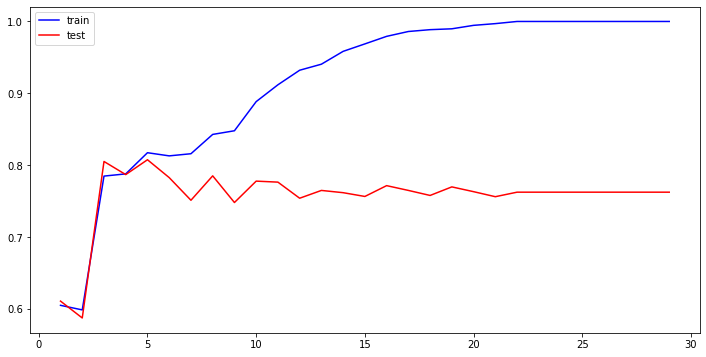

In [52]:
plt.plot(range(1,30), train_auc_list, c='b', label="train")
plt.plot(range(1,30), test_auc_list, c='r', label="test")
plt.legend();

Internalizing noise from a subset of your population (i.e., the training set) will impede predictive accuracy. Since we are concerned about predictive accuracy on new data, the sweet spot is likely the maximum of the test data AUC, accuracy or whatever metric that you consider to be most important.

## Grid search
The lecture introduced *grid-search* as a versatile approach toward model selection aka hyperparameter tuning. Let's revisit the approach. Remember that we created a range of possible settings for a hyperparameter of interest, say `depth`. Above, we achieve this using the `range()` function. This created an array of numbers from 1 to 30. We then calculated the AUC for the training and test data for candidate setting of our hyperparameter. Let's first take a look at these test AUC values:

In [53]:
test_auc_list

[0.6106853642924674,
 0.5872105655679463,
 0.8050813616851353,
 0.7868153550728467,
 0.8074860971642326,
 0.782616610585534,
 0.7510966650811267,
 0.7850653888389738,
 0.7479461386231641,
 0.7777219902636107,
 0.7763273024094334,
 0.7539242111939115,
 0.764773414606933,
 0.761634632888795,
 0.7563817980022198,
 0.7714444268273347,
 0.7647939679016261,
 0.7577852944112656,
 0.769700332963374,
 0.7630469378527093,
 0.7560470729172172,
 0.7623422534632301,
 0.7623422534632301,
 0.7623422534632301,
 0.7623422534632301,
 0.7623422534632301,
 0.7623422534632301,
 0.7623422534632301,
 0.7623422534632301]

Let's choose the index of the highest value in this list using `np.argmax()` and converting the list into an NumPy array. We will call this `optimal_depth`. Based on the experiment we have undertaken, this value is the best setting of the hyperparameter `depth`. 

In [54]:
optimal_depth = np.argmax(np.array(test_auc_list))
dt_opt = tree.DecisionTreeClassifier(max_depth=optimal_depth+1, random_state=888)
dt_opt = dt_opt.fit(X_train, y_train)
dt_opt_test_pred = dt_opt.predict(X_test)
auc_dt_opt = metrics.roc_auc_score(y_test, dt_opt_test_pred)
auc_dt_opt

0.8074860971642326

Grid search is the idea of iterating through any list of possible hyperparameter values and selecting the values which yield the best result for your model.

Very often, you will see data getting partitioned into 3 sets: train, validation and test set. The training set will be used to fit the model. We will then check the model's performance using the validation set as we tune hyperparameters. The test set will only appear in the final step to verify the model's performance on unseen data; specifically, the model with the best hyperparameters as determined using the validation data.

## Hyperparameter tuning in sklearn

We can also delegate the task of hyperparameter tuning to `sklearn`, which has some great functions to assist in this matter. Let's take a quick look at how we can choose the best regularizer using `sklearn` functions.

Our first task is to create a list of dictionaries (or just one dictionary) in which you will have `'parameter_name': list_or_array_of_values` . The algorithm will test all combinations of all possibilities (per dictionary) and return the parameters that yielded the highest accuracy.

Note that this function uses cross-validation. Like before, the training data will be split into N folds. N-1 folds will be used to train, while the final fold will act like an validation set and be used for evaluation. Afterwards, we can use a test set to verify the model's performance.

It is common to do this process for complex models, which exhibit multiple hyperparameters. We consider the RandomForest classifier for illustration and tune the two hyperparameters *number of trees* and *mtry*. Note that running the below code may take a while.

In [55]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

tuned_parameters = [{'n_estimators': [200, 400],
                     'criterion': ["gini", "entropy"]}] # you could also take min_samples_split, max_features...

grid_search = GridSearchCV(
        RandomForestClassifier(random_state=888),
        param_grid=tuned_parameters
        )
grid_search.fit(X_train, y_train.ravel())

GridSearchCV(cv=None, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False, random_state=888,
                              

Once the grid search is done, we can display the best parameters that were found. If the possible values were a continuous variable and the algorithm finds that an extreme in the range was optimal, it may be worthwhile to further extend the range to see if even higher values can give you a better score.

In [56]:
# Display the best parameters

print(grid_search.best_params_)

{'criterion': 'gini', 'n_estimators': 400}


We can also now use these parameters to predict on the test set and check its accuracy. At this point, however, it is important to task "which model does create those predictions?" After all, we trained many models in the scope of grid-search, one for each candidate set of hyperparameter values. Above, we have two hyperparameters with two candidate values each and, therefore, train $2 \times 2=4$ candidate RF models. Actually, the number of models is larger than that because we use cross-validation. By default, the number of folds is 5 in `GridSearchCV()`. Therefore, the above code does train 20 RF classifiers in total. If interested, have a look into the field `cv_results_` of the object `grid_search` to get detailed information on the candidate parameter settings and cross-validation results.  

Back to our question, which of these 20 RF classifiers generates predictions for the test set? By default, the behavior of grid-search is such that one final RF classifier is trained using the **optimal hypterparameter values** and the **full trainin set** (i.e., no cross-validation). This final model is readily available after grid-searching (so we really have trained 20+1 models above) and can be used as shown below.

In [68]:
# Predict using the best parameters

grid_search_pred = grid_search.predict_proba(X_test)  # the predict_proba call is directed to the final model with best hyperparameters

grid_search_pred

array([[0.9875, 0.0125],
       [0.555 , 0.445 ],
       [0.5875, 0.4125],
       ...,
       [0.64  , 0.36  ],
       [0.8375, 0.1625],
       [0.955 , 0.045 ]])

Evaluate model performance in the usual way...

In [69]:
fpr_grid, tpr_grid, _ = metrics.roc_curve(y_test, grid_search_pred[:,1]) 
auc_grid = metrics.auc(fpr_grid, tpr_grid)

auc_grid

0.9713046644234214

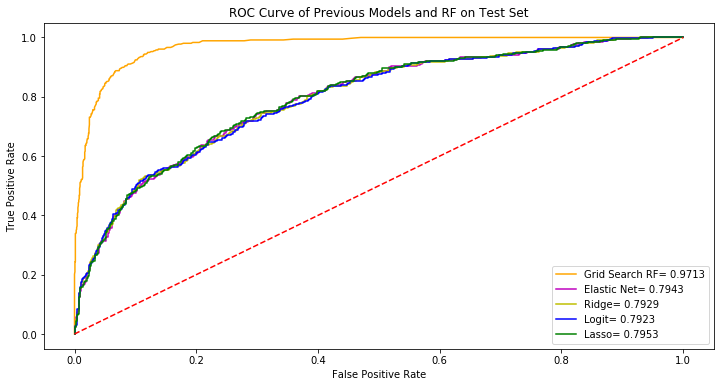

In [70]:
plt.plot(fpr_grid, tpr_grid, label="Grid Search RF= %0.4f" % auc_grid, color='orange')
plt.plot(fpr_elnet, tpr_elnet, label="Elastic Net= %0.4f" % auc_elnet, color='m')
plt.plot(fpr_ridge, tpr_ridge, label="Ridge= %0.4f" % auc_ridge, color='y')
plt.plot(fpr_logit, tpr_logit, label="Logit= %0.4f" % auc_logit, color='b')
plt.plot(fpr_lasso, tpr_lasso, label="Lasso= %0.4f" % auc_lasso, color='g')

# Random benchmark
plt.plot([0, 1], [0, 1], "r--");  

# Plot configuration
plt.title('ROC Curve of Previous Models and RF on Test Set')
plt.ylabel("True Positive Rate")
plt.xlabel("False Positive Rate")
plt.legend(loc="lower right")
plt.show()

We see that the performance of the RandomForest with Grid Search was very successful. Experimenting with different models and methods to maximize their performance is an important art in machine learning. It can make all the different in the predictions that your model will produce. 

# Conclusion
As we have seen, we can tune performance to get the most out of our models. By applying regularization, we add a little bias to our model for the benefit of lower variance.  The biased, less complex model will typically display less variation in predictive accuracy when forecasting novel observations. Trading off bias for variance is implemented  by penalizing high coefficient values in the minimization problem, which underlines model training.

We also discussed the idea of hyperparameter tuning. There are often many choices when it comes to our model's settings like depth of a tree, the penalization strength of regularization or the number of trees in a RF. Choosing the value for these hyperparameters can be tricky, but this task is made easier through functions like `GridSearchCV`. It is important to optimize choices with these values as they can be very helpful for model performance.

___

If you'd like to use the `statsmodels` library which has some awesome summary of the regression results, you can use the following functions:

| `statsmodels` | Possible Function |
| --- | --- |
| Generate logit | `sm.Logit(y, X, )` |
| Fit regular logit | `model_name.fit()` |
| Fit logit with L1 | `model_name.fit_regularized(alpha=...)` |
| Predict probabilities | `fitted_model_name.predict(X)` |
| Model moefficients | fitted_model_name.params |

Note that you must assign the fitted model to a new variable if you want to continue using it later. This is not the case for `sklearn` where the model's coefficients become an attribute.

This is also specific to logistic regression. If you would like another type of regression, it is worthwhile to check out the documentation of that regression to see what its options are.
___

`sklearn` has a bit more functions to play with. If you'd like to play with more regularization techniques, this is your one-stop-shop.

| `sklearn` | Possible Function |
| --- | --- |
| Generate logit | `LogisticRegression()` |
| Generate logit with L1 | `LogisticRegression(penalty='l1', solver='liblinear')` |
| Generate logit with L2 | `LogisticRegression(penalty='l2')` |
| Generate logit with elastic net | `LogisticRegression(penalty='elastic net', solver='saga')` |
| Fit model | `model_name.fit(X,y)` | 
| Predict probabilities | `model_name.predict_proba(X)` |
| Predict class | `model_name.predict(X)` |
| Model coefficients | `model_name.coef_` | 



Read the notes for this LogisticRegression carefully as more solvers are possible but not compatible with every form of regularization.

___

If you would like to implement grid search:

| Grid Search | Code |
| --- | --- |
| Generate grid search with CV | `GridSearchCV(model, param_grid=...)` |
| Execute grid search | `model_name.fit(X, y)` |
| Optimal parameters | `model_name.best_params_` |
| Predict probabilities | `model_name.predict_proba(X)` |

___

Other functions that we have used in this tutorial:

| Other Functions | Code |
| --- | --- |
| Split sample | `train_test_split()` |
| Cross-validation scores | `cross_val_score(model_name, X, y, cv=...)` |
| Lasso path | `lasso_path(X, y, fit_intercept=True)` |

Happy coding!